## Import Stuff

In [ ]:
from matplotlib import pyplot
from keras.datasets import cifar10
import numpy as np
from keras.applications import VGG16
from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense
from keras.engine import Model
from keras import optimizers
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import one_hot
from keras.layers import Embedding, Input, LSTM

## Revised Embedding Class
Creates a dataset ready for Visual Question Answering based on CIFAR10

for each image 2 questions are generated: 

1- Is this a {Item}? 

2- Is This a {Random other Item}

All nessecery preprocessing is done when creating an instance and all you have to do is train the image and text embedding models, and get the concatenated embeddings for the whole dataset as a new dataset for our classifier!

##Functions:

###load_cifar10: 
Loads cifar10 dataset and prints some info about it

###generate_questions: 
generates 2 questions and corresponding answers for each image-label pair
( Later the image and labels are duplicated to match the shape of the questions)

###Preprocess: 
Applies nessecery preprocessing on all data

###train_image_embedding:
Fine Tunes a VGG16 pretrained on imagenet and outputs the model. later we its one but last layer (size 20) as image embedding

###train_text_embedding: 
Trains a self-defined network consisting of an embedding layer + lstm + dense(20) + dense(10) layer and outputs the model. later its last layer is used as question embedding

###get_embedding_and_label: 
outputs a concatenation of the learnt embeddings for the train and test dataset and outputs that plus the answer labels

###get_test_sample: 
given the index of a test sample in the dataset, outputs the image, question text, and answer 

###get_train_sample:  
given the index of a train sample in the dataset, outputs the image, question text, and answer 

In [ ]:
class revised_embedding():

  classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  n_classes = 10
  vocab_size = 50
  img_width, img_height = 32, 32
  n_epoch = 20
  batch_size = 32

  def __init__(self):
    
    # Image and labels
    self.trainX = []
    self.trainy = []
    self.testX = []
    self.testy = []
    # Question and answers
    self.trainQX_txt = []
    self.trainQX = []
    self.trainQy = []
    self.testQX_txt = []
    self.testQX = []
    self.testQy = []
    
    # load dataset
    (self.trainX, self.trainy), (self.testX, self.testy) = self.load_cifar10()

    ## Temporary. for developement purposes
    #self.trainX =self. trainX[:1000]
    #self.trainy = self.trainy[:1000]
    #self.testX = self.testX[:1000]
    #self.testy = self.testy[:1000]

    # Create 2 questions for each image
    self.trainQX_txt, self.trainQy = self.generate_questions(self.trainy)
    self.testQX_txt, self.testQy = self.generate_questions(self.testy)

    # duplicate image and labels to match questions
    self.trainX = [y for x in self.trainX for y in (x,)*2]
    self.testX = [y for x in self.testX for y in (x,)*2]
    self.trainy = [y for x in self.trainy for y in (x,)*2]
    self.testy = [y for x in self.testy for y in (x,)*2]

    # Apply preprocessing
    self.preprocess()
    

  def load_cifar10(self):

    (trainX, trainy), (testX, testy) = cifar10.load_data()
    # summarize loaded dataset
    print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
    print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
    # plot an image from each label
    i = 0
    already_seen = []
    for x, y in zip(trainX, trainy):
      if len(already_seen) == 10:
        break
      # plot raw pixel data
      if y not in already_seen:
        # define subplot
        pyplot.subplot(2, 5, 1+i)
        pyplot.imshow(x)
        pyplot.title(y)
        pyplot.axis('off')
        already_seen = np.append(already_seen, y)
        i+=1
    pyplot.show()
    # Print label distributions
    unique, counts = np.unique(trainy, return_counts=True)
    print('label distribution: ')
    print(np.asarray((unique, counts)).T)
    return (trainX, trainy), (testX, testy)

  
  def generate_questions(self, labels):

    QX = []
    Qy = []
    for y in tqdm(labels):
      # Positive question
      q = 'is this a ' + self.classes[y[0]]
      QX = np.append(QX, q)
      Qy = np.append(Qy, 'yes')
      # Negative question
      q = 'is this a ' + self.classes[np.random.choice([t for t in range(len(self.classes)) if t != y])]
      QX = np.append(QX, q)
      Qy = np.append(Qy, 'no')
    return QX, Qy

  def preprocess(self):

    self.trainX = np.array(self.trainX) / 255 # Rescale images
    self.testX = np.array(self.testX) / 255
    self.trainy = np_utils.to_categorical(self.trainy, self.n_classes) # Encode labels
    self.testy = np_utils.to_categorical(self.testy, self.n_classes)
    self.trainQX = np.asarray([one_hot(d, self.vocab_size) for d in self.trainQX_txt]) # Integer encode the questions
    self.testQX = np.asarray([one_hot(d, self.vocab_size) for d in self.testQX_txt])
    enc = LabelEncoder() # Binary encode the answers (Yes/No)
    self.trainQy = enc.fit_transform(self.trainQy)
    self.testQy = enc.transform(self.testQy)

    print(np.shape(self.trainX), np.shape(self.trainQX), np.shape(self.trainy))
    print(np.shape(self.testX), np.shape(self.testQX), np.shape(self.testy))


  def train_image_embedding(self):
    
    # Load and freeze VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(self.img_width, self.img_height, 3))
    for layer in base_model.layers:
      layer.trainable = False
    # This far deep is enough cause our images are just so small
    last = base_model.get_layer('block4_pool').output

    # Add classification layers
    x = Flatten()(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu', name = 'out')(x)
    pred = Dense(10, activation='softmax')(x)
    im_model = Model(base_model.input, pred)

    im_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    print(im_model.summary())

    # Add callbacks
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                  cooldown=0,
                                  patience=5,
                                  min_lr=0.5e-6)
    early_stopping_cb = EarlyStopping(
        patience=10, restore_best_weights=True
    )
    callbacks = [lr_reducer, early_stopping_cb]

    # fine-tune the VGG
    im_model.fit(
        self.trainX, self.trainy, 
        epochs = self.n_epoch,
        batch_size = self.batch_size,
        callbacks = callbacks,
        validation_data = (self.testX, self.testy)
        )
    
    return im_model

  def train_text_embedding(self):

    # Layers
    input = Input(shape=(4))
    x = Embedding(self.vocab_size, 20, input_length=4, name='embed')(input)
    x = LSTM(20, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Flatten(name = 'out')(x)
    x = Dense(10, activation='softmax')(x)
    txt_model = Model(input, x)

    txt_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(txt_model.summary())

    # Add callbacks
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                  cooldown=0,
                                  patience=5,
                                  min_lr=0.5e-6)
    early_stopping_cb = EarlyStopping(
        patience=10, restore_best_weights=True
    )
    callbacks = [lr_reducer, early_stopping_cb]

    # fit the model
    txt_model.fit(
        self.trainQX, self.trainy, 
        epochs = self.n_epoch,
        batch_size = self.batch_size,
        callbacks = callbacks,
        validation_data = (self.testQX, self.testy)
    )

    return txt_model


  def get_embedding_and_label(self, im_model, txt_model):

    # get embedding of image model
    layer_name = 'out'
    intermediate_im_model = Model(inputs=im_model.input,
                                    outputs=im_model.get_layer(layer_name).output)
    im_train_embedding = intermediate_im_model.predict(self.trainX)
    im_test_embedding = intermediate_im_model.predict(self.testX)
    print("Image train and test embedding sizes:")
    print(im_train_embedding.shape, im_test_embedding.shape)

    # get embedding of text model
    layer_name = 'out'
    intermediate_text_model = Model(inputs=txt_model.input,
                                    outputs=txt_model.get_layer(layer_name).output)
    txt_train_embedding = intermediate_text_model.predict(self.trainQX)
    txt_test_embedding = intermediate_text_model.predict(self.testQX)
    print("Text train and test embedding sizes:")
    print(txt_train_embedding.shape, txt_test_embedding.shape)

    # Concatenate image and text embedding
    train_embedding = np.concatenate((txt_train_embedding, im_train_embedding), axis=1)
    test_embedding = np.concatenate((txt_test_embedding, im_test_embedding), axis=1)

    return (train_embedding, self.trainQy), (test_embedding, self.testQy)


  def get_test_sample(self, index):
    return self.testX[index], self.testQX_txt[index], self.testQy[index]

  def get_train_sample(self, index):
    return self.trainX[index], self.trainQX_txt[index], self.trainQy[index]


## Using Revised Embedding class to get embedded train and test data and labels

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


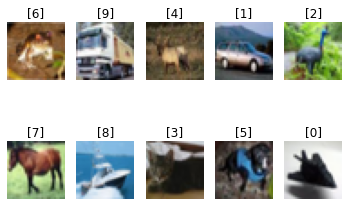

  1%|▏         | 746/50000 [00:00<00:06, 7451.18it/s]

label distribution: 
[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]


100%|██████████| 10000/10000 [00:12<00:00, 802.80it/s]


(100000, 32, 32, 3) (100000, 4) (100000, 10)
(20000, 32, 32, 3) (20000, 4) (20000, 10)
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____________________________________

In [ ]:
# Create instance 
emb = revised_embedding()
# Train image model embedding
im_model = emb.train_image_embedding()
# Train text model embedding
txt_model = emb.train_text_embedding()
# Get a concatenated embedding of image and text, and also labels for the whole train and test dataset
(train_X, train_y), (test_X, test_y) = emb.get_embedding_and_label(im_model, txt_model)


### KNN Classification using Scikit learn with 5 neighbors (tested) and print accuracy

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_X, train_y)
neigh.score(test_X, test_y)

0.7969

## Show predictions and embedding neighbors for some samples
as we can see from below, embeddings of similar items are also similar!

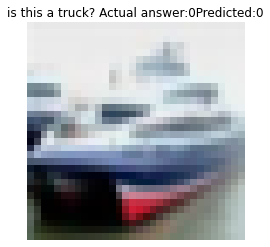

Nearest neighbors:::


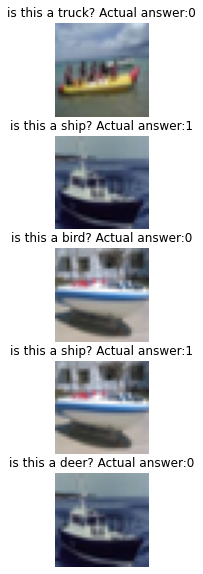

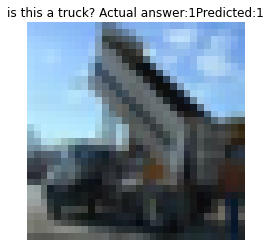

Nearest neighbors:::


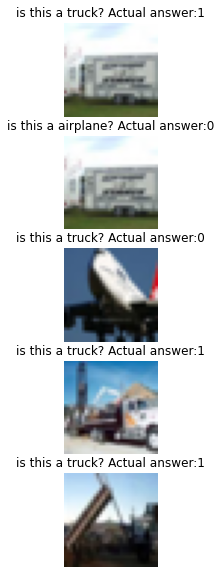

In [ ]:
ef plot_knns(index):
  # get a test sample
  im, q, y = emb.get_test_sample(index)
  pyplot.imshow(im)
  pyplot.title(str(q) + "? Actual answer:" + str(y) + "Predicted:" + str(neigh.predict(test_X[index].reshape(1, -1))[0]))
  pyplot.axis('off')
  pyplot.show();

  # Get nearest neighbors of that sample
  print("Nearest neighbors:::")
  neighbors = neigh.kneighbors([test_X[index]], return_distance=False)

  pyplot.figure(figsize=(10,10))
  for i, neighbor in enumerate(neighbors[0]):
    im, q, y = emb.get_train_sample(neighbor)
    pyplot.subplot(len(neighbors[0]), 1, i+1)
    pyplot.imshow(im)
    pyplot.axis('off')
    pyplot.title(str(q) + "? Actual answer:" + str(y))
  pyplot.show();

plot_knns(3)
plot_knns(100)